In [51]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from typing import List, Tuple
import math

In [52]:
Point = Tuple[float, float]
Line = Tuple[Point, Point]

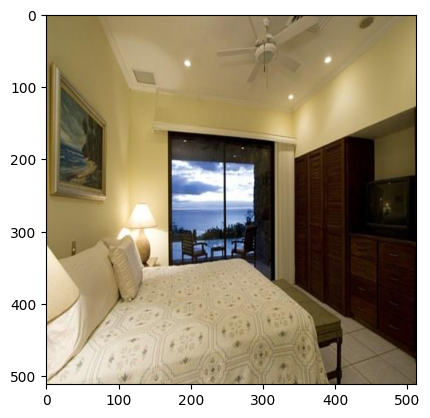

In [53]:
i = 40

image = np.array(Image.open(f'/Users/richardkuodis/development/pytorch-layoutnet/res/lsun_tr_gt/img/{i}.png'))
plt.imshow(image);

In [54]:
lines = [
    ((116, 100), (72, 0)),
    ((116, 396), (64, 511)),
    ((344, 370), (511, 479)),
    ((342, 133), (496, 0)),
    ((116, 100), (116, 396)),
    ((116, 396), (344, 370)),
    ((344, 370), (342, 133)),
    ((342, 133), (116, 100))
]

# lines = [
#     ((116, 100), (72, 0)),
#     ((116, 396), (64, 511)),
#     ((344, 370), (511, 479)),
#     ((342, 133), (496, 0)),
    
#     ((60, 100), (116, 396)),

#     ((116, 396), (344, 370)),

#     ((344, 370), (240, 133)),

#     ((342, 133), (116, 100))
# ]


colors = [
    (255, 0, 0), # Red
    (0, 255, 0), # Green
    (0, 0, 255), # Blue
    (255, 255, 0), # Yellow
    (255, 102, 178), # Pink
    (102, 255, 255), # Cyan
    (255, 255, 255), #  White
    (255, 153, 51), # Orange
]

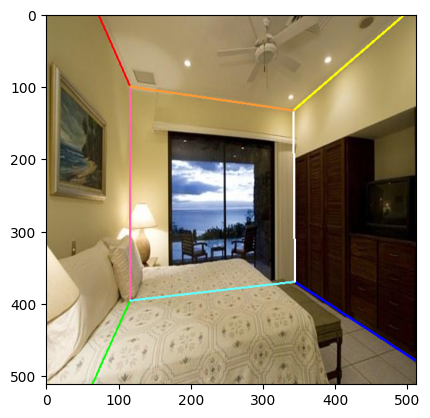

In [55]:
image_overlay = image.copy()

for line_idx, (p1, p2) in enumerate(lines):
    image_overlay = cv2.line(
        image_overlay,
        p1, 
        p2, 
        colors[line_idx],
        2
    )

plt.imshow(image_overlay);

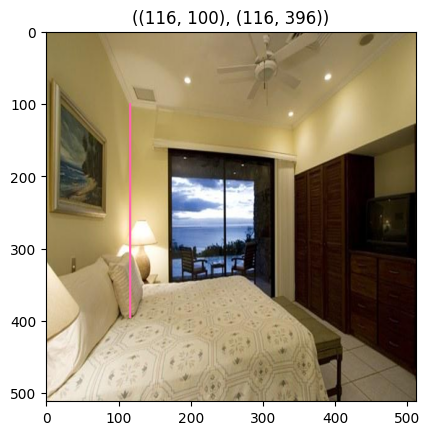

In [56]:
line_idx = 4

line = lines[line_idx]

# FIXME: for debug
line = (
    (line[0][0], line[0][1]),
    (line[1][0], line[1][1])
)

image_tmp = image.copy()

image_tmp = cv2.line(
    image_tmp,
    line[0], 
    line[1], 
    colors[line_idx],
    2
)

plt.imshow(image_tmp)
plt.title(f'{line}');

In [57]:
def line_image_coords_to_geo(lines, size=(512, 512)):
    """
    Converts lines coordinates from image space to geometry
    """
    width, height = size

    lines_geo = []
    for (p1, p2) in lines:
        p1 = (p1[0], height -1 - p1[1])
        p2 = (p2[0], height -1 - p2[1])
        lines_geo.append((p1, p2))
    
    return lines_geo

def line_geo_coords_to_image(lines, size=(512, 512)):
    width, height = size

    lines_geo = []
    for (p1, p2) in lines:
        p1 = (p1[0], height -1 - p1[1])
        p2 = (p2[0], height -1 - p2[1])
        lines_geo.append((p1, p2))
    
    return lines_geo

In [58]:
lines_geo = line_image_coords_to_geo(lines)
lines_geo

[((116, 411), (72, 511)),
 ((116, 115), (64, 0)),
 ((344, 141), (511, 32)),
 ((342, 378), (496, 511)),
 ((116, 411), (116, 115)),
 ((116, 115), (344, 141)),
 ((344, 141), (342, 378)),
 ((342, 378), (116, 411))]

In [59]:
line_geo = lines_geo[line_idx]

line_geo, line

(((116, 411), (116, 115)), ((116, 100), (116, 396)))

Compute left ending line params

In [60]:
def compute_line_params(line):
    if line[0][0] == line[1][0]:
        padding = 0.00001
    else:
        padding = 0.
    
    a, b = np.polyfit(
        [line[0][0], line[1][0] + padding],
        [line[0][1], line[1][1]],
        1
    )
    return a, b

In [61]:
a, b = compute_line_params(line_geo)

print(f'Left line equation: {a:0.4f}x + {b:0.4f}')

Left line equation: -29599999.9716x + 3433600407.7082


In [62]:
def compute_y_at_x(a, b, x):
    return a * x + b

def compute_x_at_y(a, b, y):
    # y = a*x + b => ax = y - b => x = (y - b) / a
    return (y - b) / a

In [63]:
a

-29599999.971622553

In [64]:
if a > 0:
    # If left line slope is greater than zero, that is, line goes to top-right: /,
    # then left ending line shall touch top-left point
    print('Slope is greater than zero, left line will touch top left bound of the image')
    corner_point = (0, 511)
else:
    # Line goes to bottom-right: \
    # It shall touch the bottom left point
    print('Slope is less than zero, left line will touch bottom left bound of the image')
    corner_point = (0, 0)

print(f'Corner point: {corner_point}')

Slope is less than zero, left line will touch bottom left bound of the image
Corner point: (0, 0)


In [65]:
def compute_line_intercept(a, x, y):
    # y = ax + b => b = y - ax
    return y - a * x

In [66]:
x, y = corner_point


b_left = compute_line_intercept(a, x, y)

b_left

0.0

In [67]:
def compute_lines_intersection(a1, b1, a2, b2):
    """
    Given two lines 'y = a1 * x + b2 and 'y = a2 * x + b2', finds point of intersection (x, y).

    a2 * x + b2 = a1 * x + b1
    a2 * x - a1 * x = b1 - b2
    (a2 - a1) * x = b1 - b2
    x = (b1 - b2) / (a2 - a1)
    """

    x = (b1 - b2) / (a2 - a1)
    y = a1 * x + b1 # or y = a2 * x + b2, doesn't matter
    return (x, y)

In [68]:
# Now we need to find where left line intersect with with top and bottom lines
line_top = lines_geo[0]

a_top, b_top = compute_line_params(line_top)

top_intersection_point = compute_lines_intersection(a, b_left, a_top, b_top)

top_intersection_point

(-2.279177081360186e-05, 674.6364154358428)

In [69]:
line_bottom = lines_geo[1]

a_bottom, b_bottom = compute_line_params(line_bottom)

bottom_intersection_point = compute_lines_intersection(a, b_left, a_bottom, b_bottom)

bottom_intersection_point

(4.781704429028066e-06, -141.53845096353817)

In [70]:
line_left = (top_intersection_point, bottom_intersection_point)

line_top = (line_top[0], top_intersection_point)
line_bottom = (line_bottom[0], bottom_intersection_point)

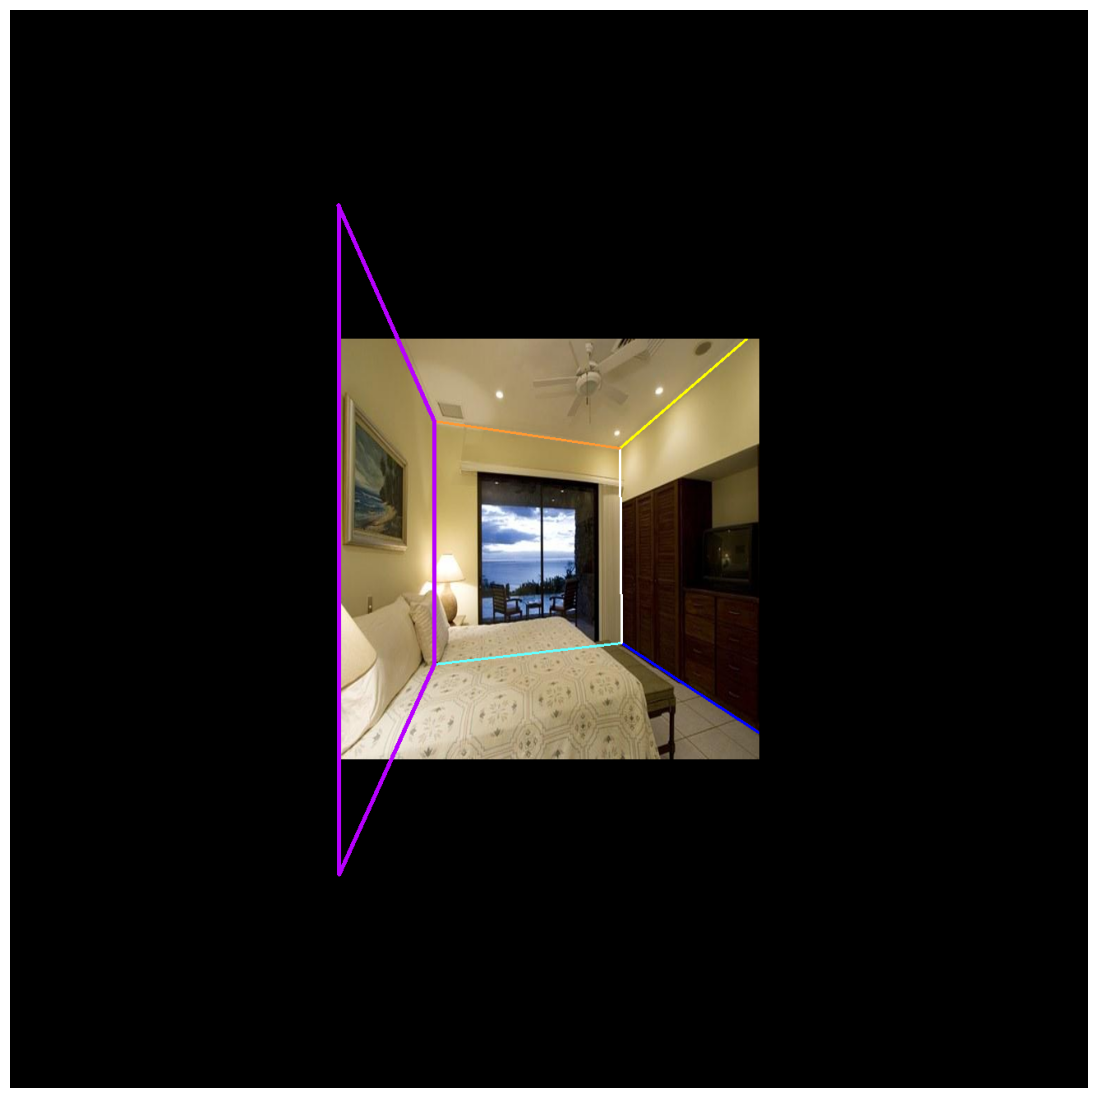

In [71]:
left_lines_geo = [
    line_top,
    line_geo,
    line_bottom,
    line_left
]

left_lines_image = line_geo_coords_to_image(left_lines_geo)

padding = 400

padded_image = np.pad(image_overlay, pad_width=[(padding, padding), (padding, padding), (0, 0)], mode='constant')

for p1, p2 in left_lines_image:
    image_tmp2 = cv2.line(
        padded_image,
        (int(p1[0]) + padding, int(p1[1]) + padding), 
        (int(p2[0] + padding), int(p2[1]) + padding), 
        (183, 0, 255),
        3
    )

plt.figure(figsize=(14, 14))
plt.axis('off')
plt.imshow(padded_image);

In [72]:
# Now compute the right polygon
line_geo = lines_geo[6]

a, b = compute_line_params(line_geo)

print(f'Right line equation: {a:0.4f}x + {b:0.4f}')

Right line equation: -118.5000x + 40905.0000


In [73]:
if a > 0:
    corner_point = (511, 0)
else:
    corner_point = (511, 511)

print(f'Corner point: {corner_point}')

Corner point: (511, 511)


In [74]:
x, y = corner_point

b_right = compute_line_intercept(a, x, y)

b_right

61064.500000001564

In [75]:
line_top = lines_geo[3]

a_top, b_top = compute_line_params(line_top)

top_intersection_point = compute_lines_intersection(a, b_right, a_top, b_top)

top_intersection_point

(510.8914699162225, 523.8608149276406)

In [76]:
line_bottom = lines_geo[2]

a_bottom, b_bottom = compute_line_params(line_bottom)

bottom_intersection_point = compute_lines_intersection(a, b_right, a_bottom, b_bottom)

bottom_intersection_point

(515.0645816925382, 29.347069434210425)

In [77]:
line_right = (top_intersection_point, bottom_intersection_point)

line_top = (line_top[0], top_intersection_point)
line_bottom = (line_bottom[0], bottom_intersection_point)

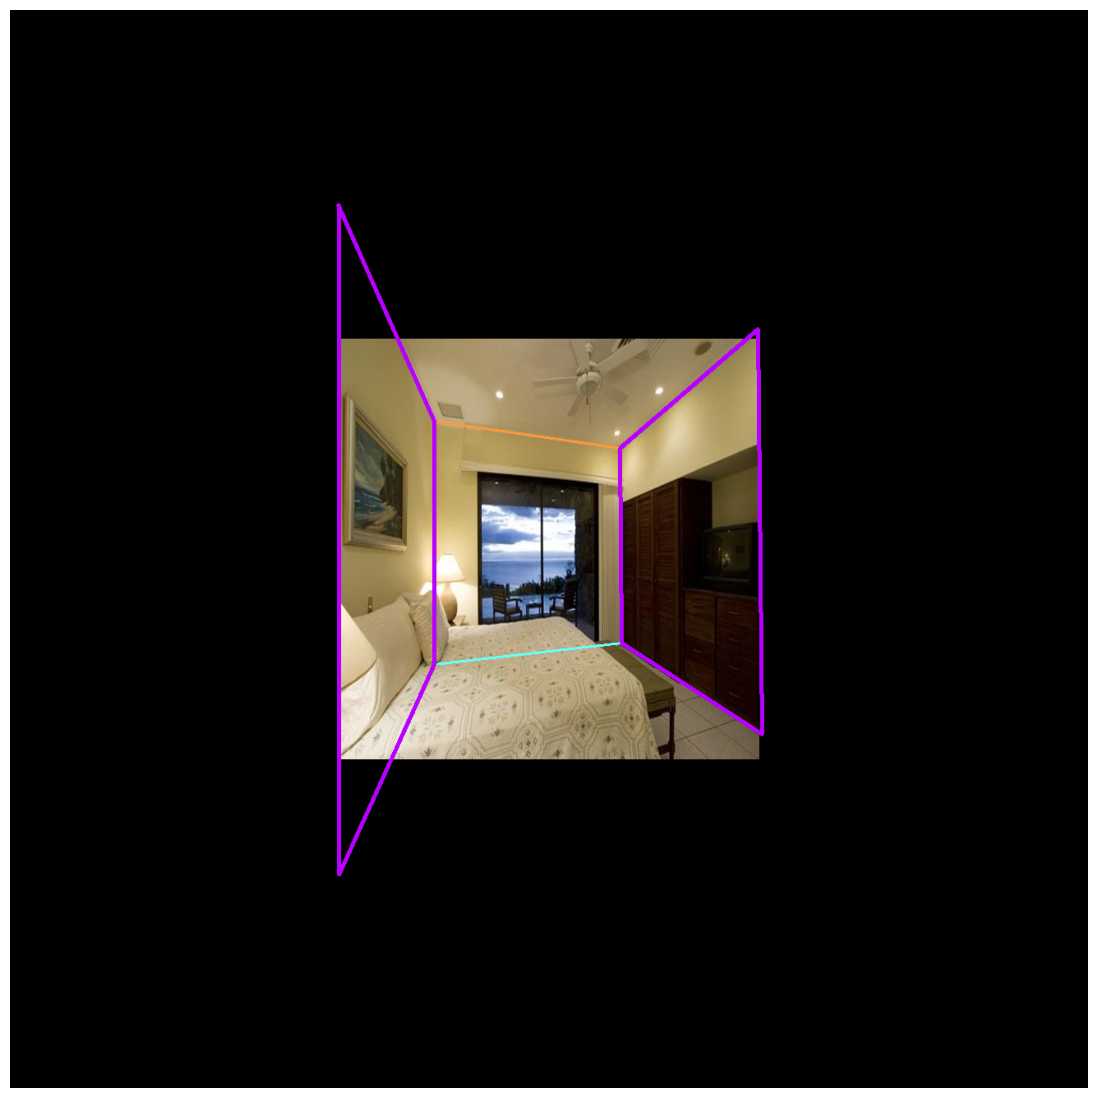

In [78]:
right_lines_geo = [
    line_top,
    line_geo,
    line_bottom,
    line_right
]

right_lines_image = line_geo_coords_to_image(right_lines_geo)

padding = 400

# padded_image = np.pad(image_overlay, pad_width=[(padding, padding), (padding, padding), (0, 0)], mode='constant')

for p1, p2 in right_lines_image:
    image_tmp2 = cv2.line(
        padded_image,
        (int(p1[0]) + padding, int(p1[1]) + padding), 
        (int(p2[0] + padding), int(p2[1]) + padding), 
        (183, 0, 255),
        3
    )

plt.figure(figsize=(14, 14))
plt.axis('off')
plt.imshow(padded_image);

In [79]:
# Assemble polygons
line_center_left = lines[4]
line_center_top = lines[7]
line_center_bottom = lines[5]
line_center_right = lines[6]
line_top_left = lines[0]
line_bottom_left = lines[1]
line_top_right = lines[3]
line_bottom_right = lines[2]

line_left_left = line_geo_coords_to_image([line_left])[0]
line_right_right = line_geo_coords_to_image([line_right])[0]

# Left polygon
# Point order: top_left, top_right, bottom_right, bottom_left
polygon_left = [
    line_left_left[1],
    line_center_left[1],
    line_center_left[0],
    line_left_left[0]
]
print(f'Left polygon: {polygon_left}')

polygon_center = [
    line_center_left[0],
    line_center_right[1],
    line_center_right[0],
    line_center_left[1]
]

polygon_right = [
    line_center_right[1],
    line_right_right[0],
    line_right_right[1],
    line_center_right[0]
]

Left polygon: [(4.781704429028066e-06, 652.5384509635381), (116, 396), (116, 100), (-2.279177081360186e-05, -163.63641543584276)]


In [80]:
line_geo_coords_to_image([line_right])[0]

((510.8914699162225, -12.860814927640604),
 (515.0645816925382, 481.6529305657896))

In [81]:
line_right

((510.8914699162225, 523.8608149276406),
 (515.0645816925382, 29.347069434210425))

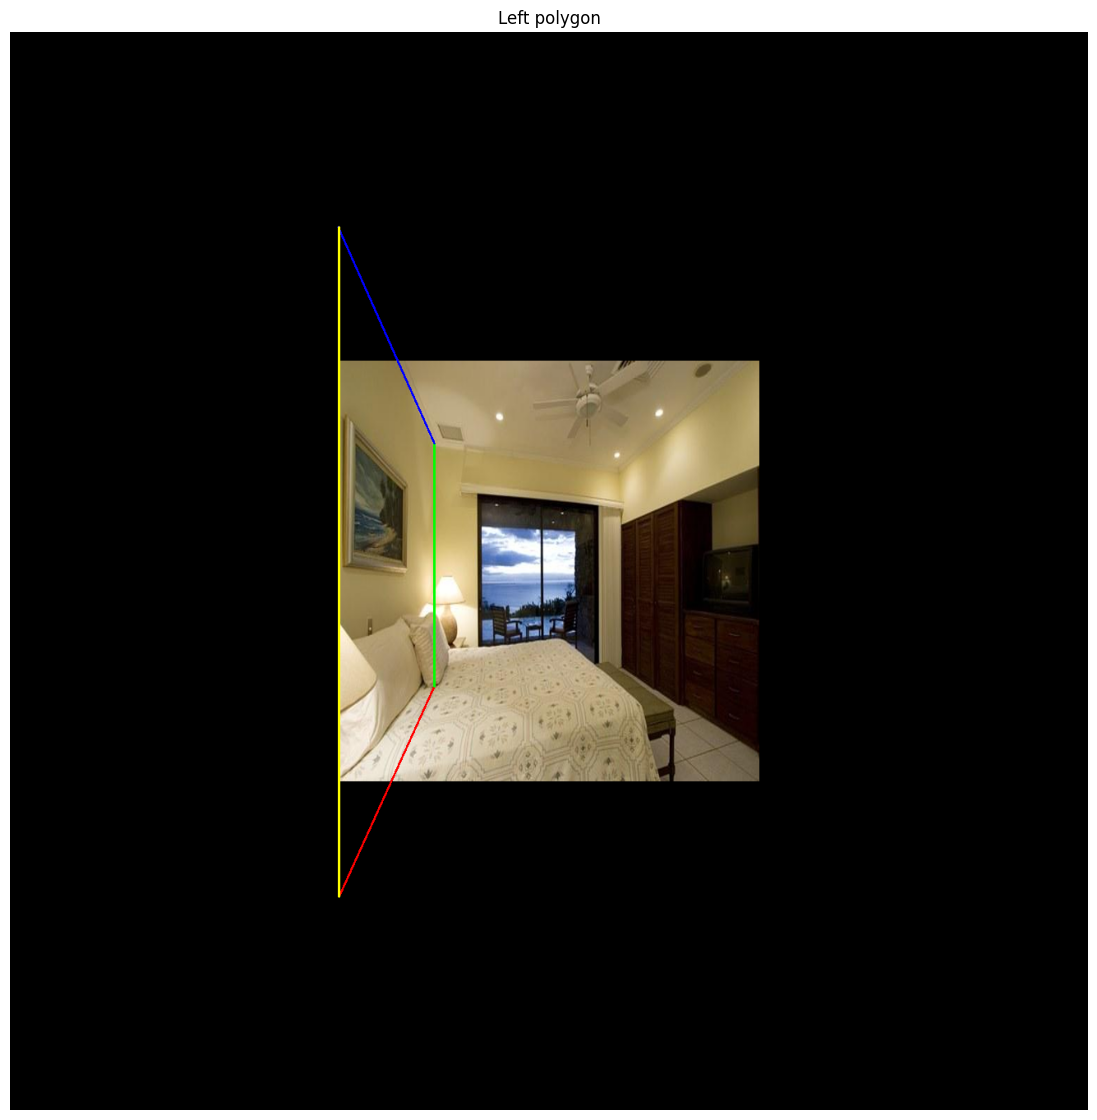

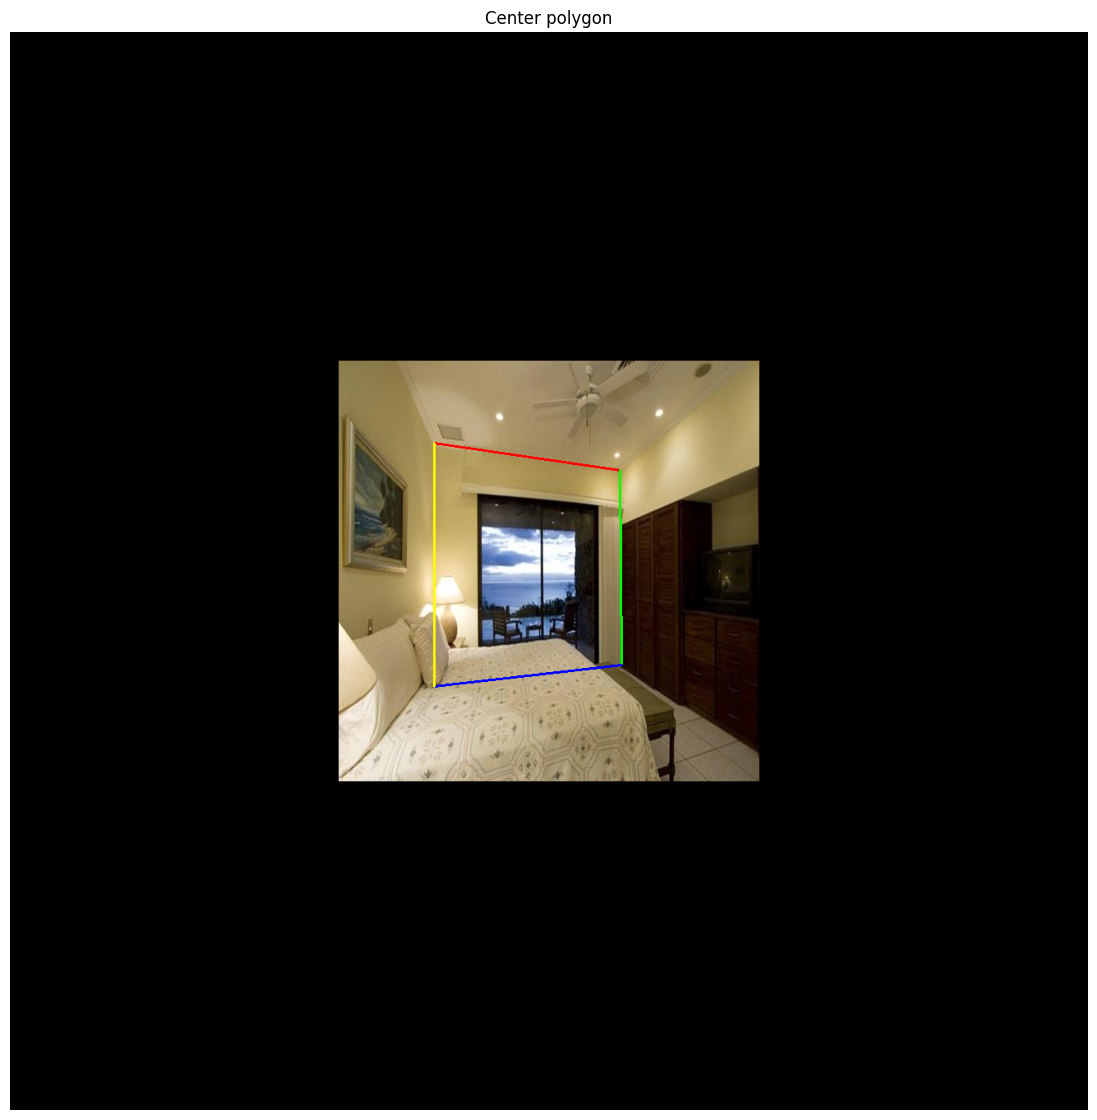

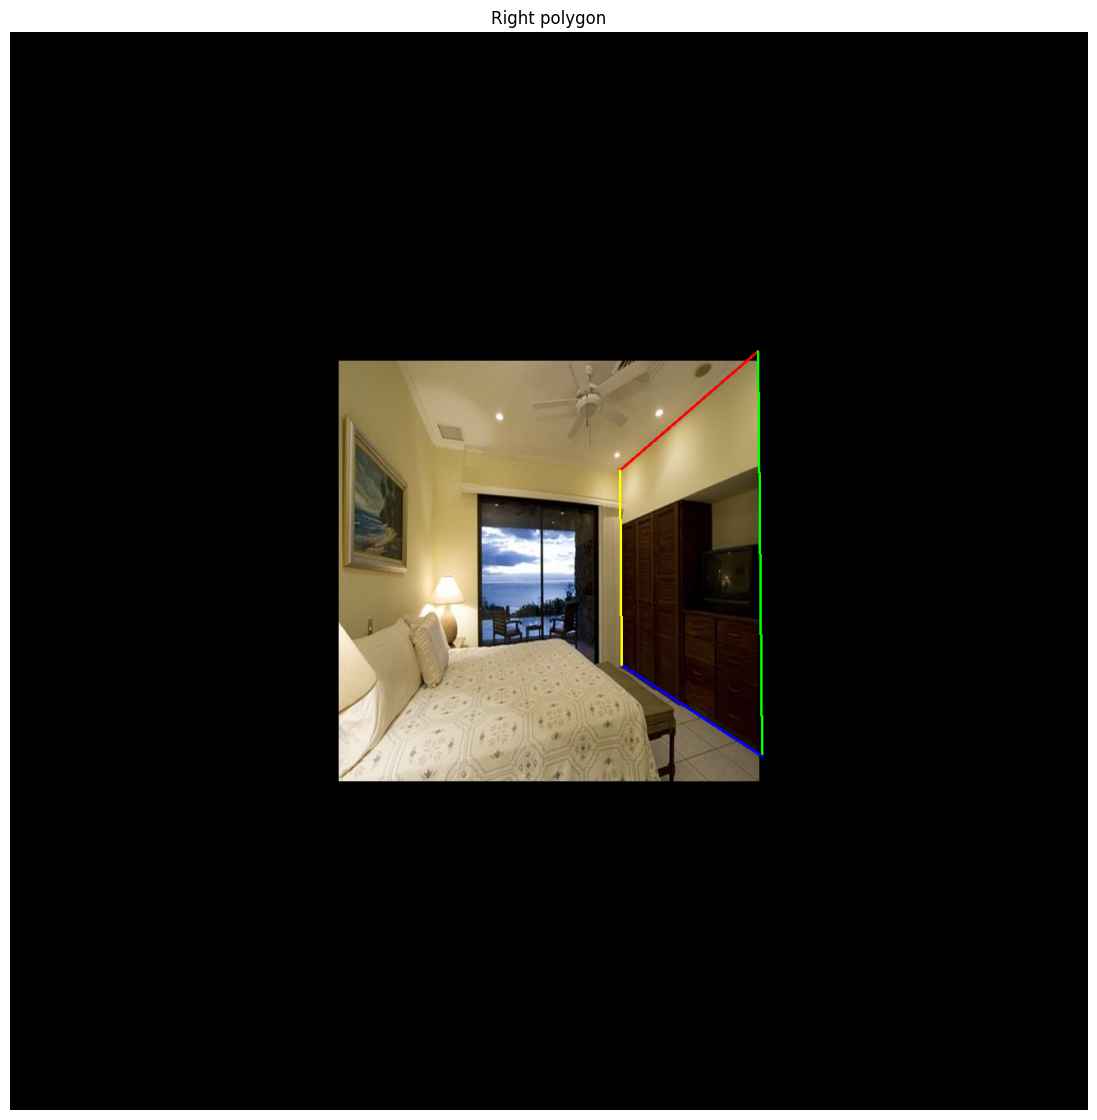

In [82]:
padding = 400

padded_image = np.pad(image, pad_width=[(padding, padding), (padding, padding), (0, 0)], mode='constant')

polygon_image = padded_image.copy()
for i in range(0, 4):
    p1 = polygon_left[i]
    p2 = polygon_left[(i + 1) % 4]
    cv2.line(
        polygon_image,
        (int(p1[0]) + padding, int(p1[1]) + padding), 
        (int(p2[0] + padding), int(p2[1]) + padding), 
        colors[i],
        2
    )

plt.figure(figsize=(14, 14))
plt.title('Left polygon')
plt.axis('off')
plt.imshow(polygon_image);

# Center
polygon_image = padded_image.copy()
for i in range(0, 4):
    p1 = polygon_center[i]
    p2 = polygon_center[(i + 1) % 4]
    cv2.line(
        polygon_image,
        (int(p1[0]) + padding, int(p1[1]) + padding), 
        (int(p2[0] + padding), int(p2[1]) + padding), 
        colors[i],
        2
    )

plt.figure(figsize=(14, 14))
plt.title('Center polygon')
plt.axis('off')
plt.imshow(polygon_image);

# Right
polygon_image = padded_image.copy()
for i in range(0, 4):
    p1 = polygon_right[i]
    p2 = polygon_right[(i + 1) % 4]
    cv2.line(
        polygon_image,
        (int(p1[0]) + padding, int(p1[1]) + padding), 
        (int(p2[0] + padding), int(p2[1]) + padding), 
        colors[i],
        2
    )

plt.figure(figsize=(14, 14))
plt.title('Right polygon')
plt.axis('off')
plt.imshow(polygon_image);

### Room Type 2

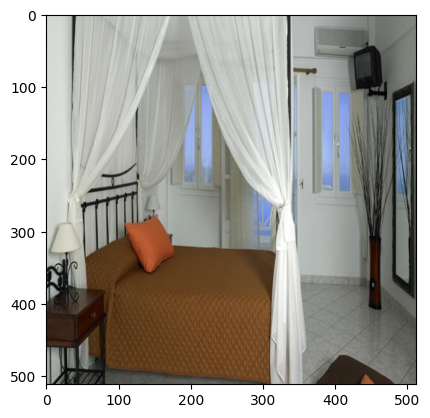

In [83]:
i = 135

image = np.array(Image.open(f'/Users/richardkuodis/development/pytorch-layoutnet/res/lsun_tr_gt/img/{i}.png'))
plt.imshow(image);

In [84]:
lines = [
    ((153, 365), (154, 1)),
    ((153, 365), (24, 512)),
    ((153, 365), (441, 375)),
    ((441, 375), (446, 1)),
    ((441, 375), (512, 440))
]

colors = [
    (255, 0, 0), # Red
    (0, 255, 0), # Green
    (0, 0, 255), # Blue
    (255, 255, 0), # Yellow
    (255, 102, 178), # Pink
    (102, 255, 255), # Cyan
    (255, 255, 255), #  White
    (255, 153, 51), # Orange
]

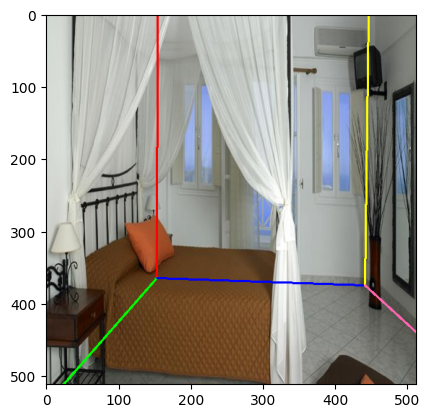

In [85]:
image_overlay = image.copy()

for line_idx, (p1, p2) in enumerate(lines):
    image_overlay = cv2.line(
        image_overlay,
        p1, 
        p2, 
        colors[line_idx],
        2
    )

plt.imshow(image_overlay);

In [86]:
lines_geo = line_image_coords_to_geo(lines)

lines_geo

[((153, 146), (154, 510)),
 ((153, 146), (24, -1)),
 ((153, 146), (441, 136)),
 ((441, 136), (446, 510)),
 ((441, 136), (512, 71))]

In [87]:
line1 = lines_geo[0]
a1, b1 = compute_line_params(line1)
theta1 = np.arctan(a1)

line2 = lines_geo[1]
a2, b2 = compute_line_params(line2)
theta2 = np.arctan(a2)

theta3 = 2 * theta1 - theta2
a3 = np.tan(theta3)

# Line should cross from either line1 top point, or top-left corner
if a3 >= 0:
    corner_point = (0, 511)
else:
    corner_point = line1[1]

print(f'Corner point: {corner_point}')

b3 = compute_line_intercept(a3, corner_point[0], corner_point[1])

line3 = (
    (-100, compute_y_at_x(a3, b3, -100)),
    (200, compute_y_at_x(a3, b3, 200))
)

a3, b3

Corner point: (154, 510)


(-1.1522438923324494, 687.4455594191973)

In [88]:
# Line 4, left-left line, is parallel to line1
a4 = a1

if a4 >= 0:
    # Top-left
    corner_point = (0, 511)
else:
    # Bottom-left
    corner_point = (0, 0)

b4 = compute_line_intercept(a4, corner_point[0], corner_point[1])

line4 = (
    (-100, compute_y_at_x(a4, b4, -100)),
    (200, compute_y_at_x(a4, b4, 200))
)

In [89]:
# Extend line2 for better visibility
line2 = (
    (-100, compute_y_at_x(a2, b2, -100)),
    (511, compute_y_at_x(a2, b2, 511))
)

In [90]:
def show_lines_image(
    image: np.ndarray, 
    lines: List[Line], 
    padding: int = 400
):
    padded_image = np.pad(
        image,
        pad_width=[(padding, padding), (padding, padding), (0, 0)],
        mode='constant'
    )

    for i, (p1, p2) in enumerate(lines):
        cv2.line(
            padded_image,
            (int(p1[0]) + padding, int(p1[1]) + padding), 
            (int(p2[0] + padding), int(p2[1]) + padding), 
            colors[i % len(colors)],
            2
        )

    plt.figure(figsize=(14, 14))
    plt.imshow(padded_image)


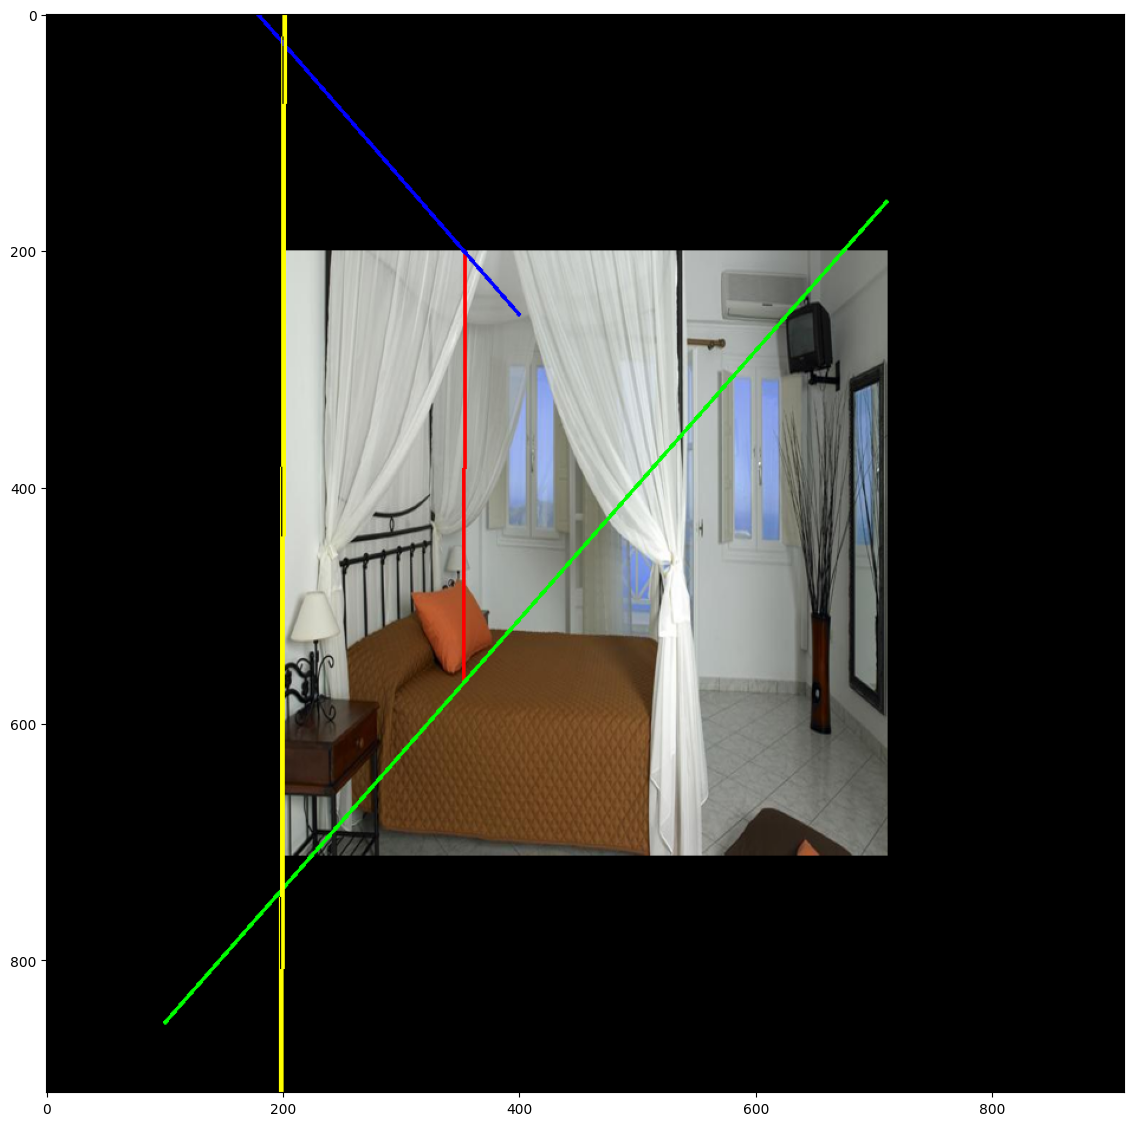

In [91]:
show_lines_image(
    image,
    line_geo_coords_to_image([line1, line2, line3, line4]),
    padding=200
)

In [92]:
# Right line
line1 = lines_geo[3]
a1, b1 = compute_line_params(line1)
theta1 = np.arctan(a1)

line2 = lines_geo[4]
a2, b2 = compute_line_params(line2)
theta2 = np.arctan(a2)

theta3 = 2 * theta1 - theta2
a3 = np.tan(theta3)

if a3 <= 0:
    corner_point = (511, 511)
else:
    corner_point = line1[1]

print(corner_point)

b3 = compute_line_intercept(a3, corner_point[0], corner_point[1])

line3 = (
    (0, compute_y_at_x(a3, b3, 0)),
    (720, compute_y_at_x(a3, b3, 720))
)

a3, b3

(446, 510)


(0.8675111115523889, 123.09004424763452)

In [93]:
a4 = a1

# if line2[1][0] > 511:
#     corner_point = line2[1][0]
if a4 >= 0:
    # Bottom-right
    corner_point = (511, 0)
else:
    # Top-right
    corner_point = (511, 511)

b4 = compute_line_intercept(a4, corner_point[0], corner_point[1])

line4 = (
    (0, compute_y_at_x(a4, b4, 0)),
    (720, compute_y_at_x(a4, b4, 720))
)

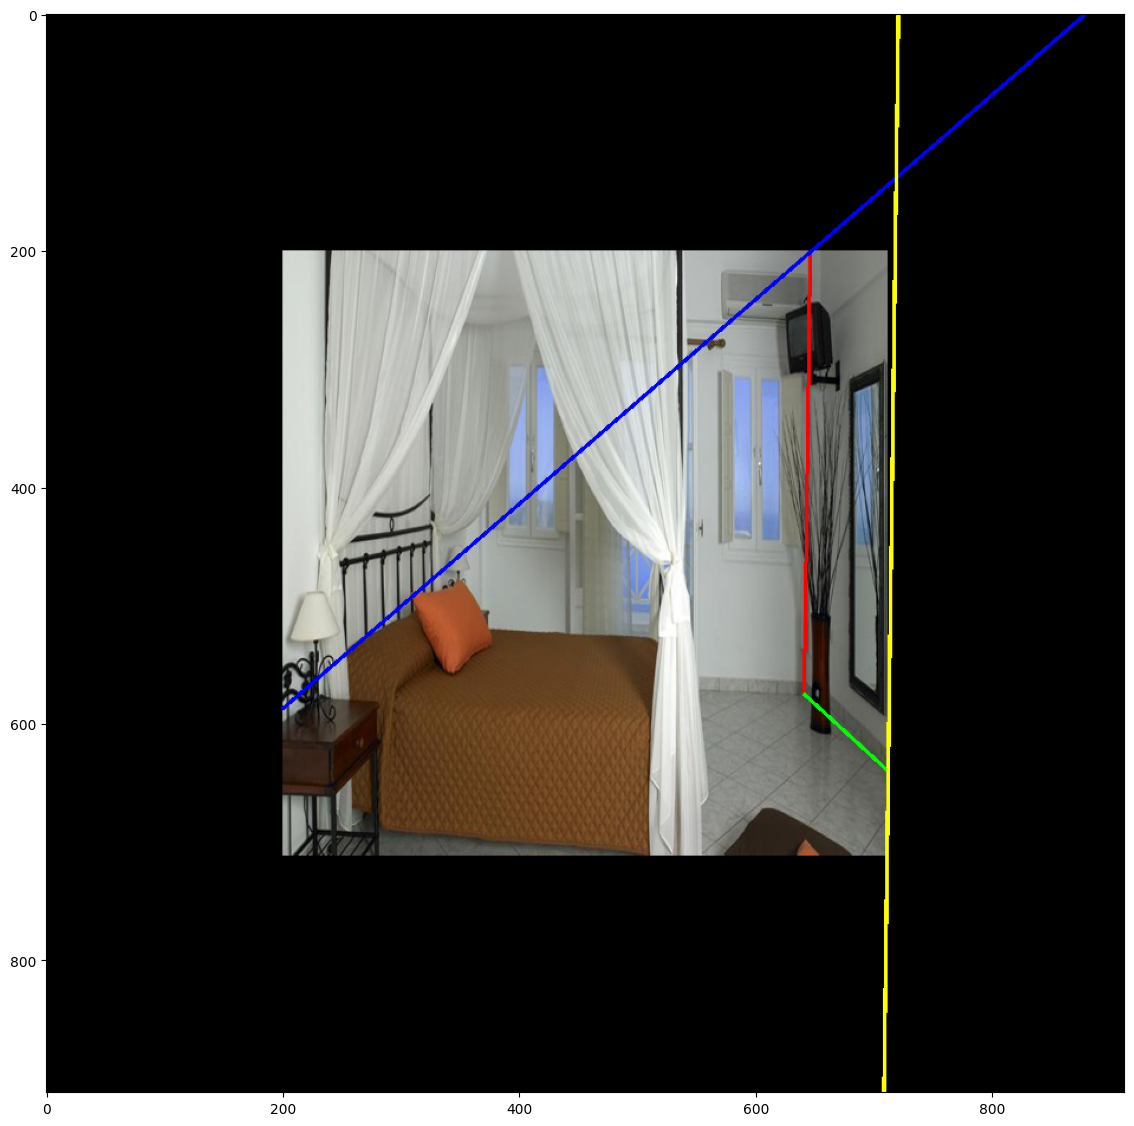

In [94]:
show_lines_image(
    image,
    line_geo_coords_to_image([line1, line2, line3, line4]),
    padding=200
)

In [95]:
def compute_line_length(line: Line) -> float:
    x1, y1 = line[0]
    x2, y2 = line[1]
    
    return math.sqrt(abs(x2 - x1) ** 2 + abs(y2 - y1) ** 2)

compute_line_length(((0, 0), (3, 4)))

5.0

In [100]:
# Center polygon
line1 = lines_geo[0]
line2 = lines_geo[3]
line3 = lines_geo[2]
a3, b3 = compute_line_params(line3)

a4 = a3
# line1_length = compute_line_length(line1)
# line2_length = compute_line_length(line2)
# if line1_length > line2_length:
#     x = line1[1][0]
# else:
#     x = line2[1][0]

if line1[0][1] < line2[0][1]:
    x = line1[1][0]
else:
    x = line2[1][0]
    
b4 = compute_line_intercept(a4, x, 511)

a4, b4

line4 = (
    (0, compute_y_at_x(a4, b4, 0)),
    (511, compute_y_at_x(a4, b4, 511))
)

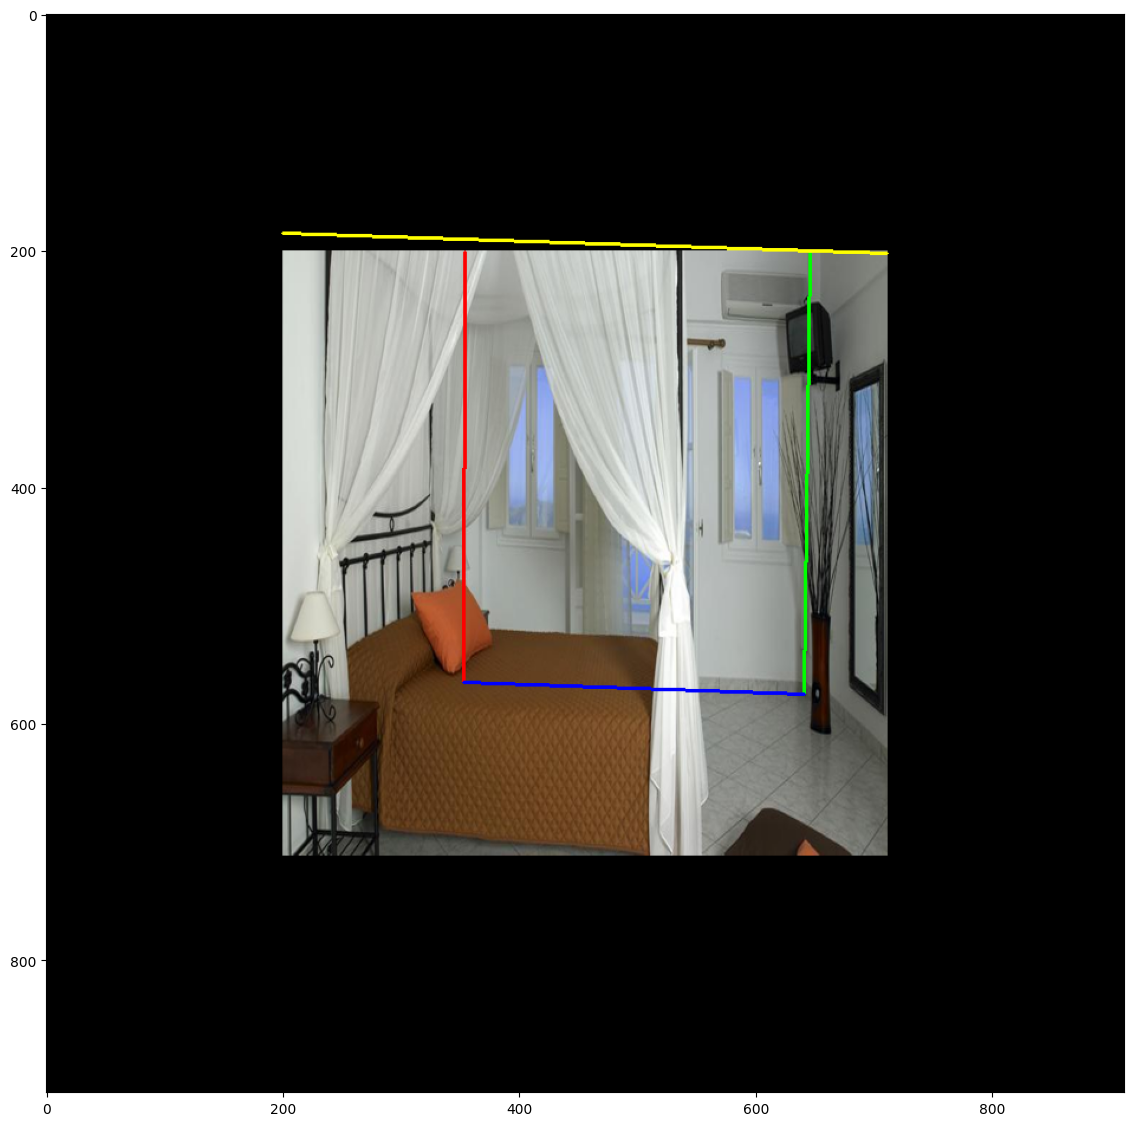

In [101]:
show_lines_image(
    image,
    line_geo_coords_to_image([line1, line2, line3, line4]),
    padding=200
)